# Necessary Installations

In [5]:
pip install --upgrade spacy

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.10.0
    Uninstalling typer-0.10.0:
      Successfully uninstalled typer-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.7.4 which is incompatible.
medspacy 1.1.5 requires spacy<3.6,>=3.4.1, but you have spacy 3.7.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade typer click

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: typer
    Found existing installation: typer 0.3.2
    Uninstalling typer-0.3.2:
      Successfully uninstalled typer-0.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.10.0 which is incompatible.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.7.4 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.10.0 which is incompatible.
medspacy 1

In [6]:
pip install openai==0.28

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Necessary Imports

In [24]:
import json
from collections import Counter
import os
import spacy
import ast
from spacy import displacy
import requests
import time
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
import pandas as pd
pd.set_option('display.max_rows', None)  # None means show all rows
pd.set_option('display.max_columns', None)  # None means show all columns
pd.set_option('display.width', None)  # None means auto-detect the display width
pd.set_option('display.max_colwidth', None)  # None means show full width of columns
import openai
openai.api_type = "azure"
openai.api_base = <your api base>
openai.api_version = <api version>
openai.api_key = <api key>

In [25]:
df_train_ms = pd.read_csv('MEDIQA-CORR-2024-MS-TrainingData.csv')
df_val_ms = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv')
df_val_uw = pd.read_csv('MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv')

In [26]:
df_train_ms.shape

(2189, 9)

In [5]:
df_train_ms.sample(3)

,Unnamed: 0,Text ID,Text,Sentences,Error Flag,Error Sentence ID,Error Sentence,Corrected Sentence,Corrected Text
2092,2092,ms-train-2092,A 55-year-old patient is brought to the emerge...,0 A 55-year-old patient is brought to the emer...,1,7,Nitroglycerin was administered to the patient ...,Patient's aspirin dose is increased based on t...,A 55-year-old patient is brought to the emerge...
1387,1387,ms-train-1387,A 4-year old boy is brought to the emergency d...,0 A 4-year old boy is brought to the emergency...,0,-1,NaN,NaN,NaN
2123,2123,ms-train-2123,A previously healthy 8-year-old boy is brought...,0 A previously healthy 8-year-old boy is broug...,0,-1,NaN,NaN,NaN


# Creating a subset from these files (For testing purposes):

1. MEDIQA-CORR-2024-MS-TrainingData.csv
2. MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv
3. MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv

In [158]:
df_train_ms = pd.read_csv('MEDIQA-CORR-2024-MS-TrainingData.csv',index_col=0)
df_val_ms = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv',index_col=0)
df_val_uw = pd.read_csv('MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv',index_col=0)
min_count = min(df_combined['Error Flag'].value_counts().min(), 50)
sampled_df = df_combined.groupby('Error Flag').sample(n=min_count, random_state=42)
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

columns_to_merge = ["Text ID", "GPT_4_error_flag", "GPT_4_sentence_id", "GPT_4_Error_Sentence", "GPT_4_Corrected_Sentence"]
case_1_df = pd.read_csv('case_1.csv')
sampled_df = sampled_df.merge(case_1_df[columns_to_merge], on="Text ID", how="left")
sampled_df[["GPT_4_error_flag", "GPT_4_sentence_id", "GPT_4_Error_Sentence", "GPT_4_Corrected_Sentence"]] = sampled_df[["GPT_4_error_flag", "GPT_4_sentence_id", "GPT_4_Error_Sentence", "GPT_4_Corrected_Sentence"]].fillna('')

sampled_df.to_csv('sampled_ms_uw_df_ea_shared_task.csv',index=False)

df_train_ms: (2189, 8)
df_val_ms: (574, 8)
df_val_uw: (160, 8)
Combined dataframe: (2923, 8)


In [181]:
df_train_ms = pd.read_csv('MEDIQA-CORR-2024-MS-TrainingData.csv',index_col=0)
df_val_ms = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv',index_col=0)
df_val_uw = pd.read_csv('MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv',index_col=0)

df_combined = pd.concat([df_train_ms, df_val_ms, df_val_uw], ignore_index=True)
print(f"df_train_ms: {df_train_ms.shape}\ndf_val_ms: {df_val_ms.shape}\ndf_val_uw: {df_val_uw.shape}\nCombined dataframe: {df_combined.shape}")

size_train_ms = df_train_ms.shape[0]
size_val_ms = df_val_ms.shape[0]
size_val_uw = df_val_uw.shape[0]
total_size = size_train_ms + size_val_ms + size_val_uw

proportion_train_ms = size_train_ms / total_size
proportion_val_ms = size_val_ms / total_size
proportion_val_uw = size_val_uw / total_size

samples_train_ms = int(round(proportion_train_ms * 300))
samples_val_ms = int(round(proportion_val_ms * 300))
samples_val_uw = 300 - samples_train_ms - samples_val_ms

def sample_balanced(df, n_samples):
    df_error = df[df["Error Flag"] == 1]
    df_no_error = df[df["Error Flag"] == 0]
    n_samples_each = n_samples // 2    
    if n_samples % 2 != 0:
        n_samples_each += 1
    sampled_error = df_error.sample(n=min(n_samples_each, len(df_error)), replace=False)
    sampled_no_error = df_no_error.sample(n=min(n_samples_each, len(df_no_error)), replace=False)
    return pd.concat([sampled_error, sampled_no_error]).sample(frac=1)  # Randomize order

sampled_train_ms = sample_balanced(df_train_ms, samples_train_ms)
sampled_val_ms = sample_balanced(df_val_ms, samples_val_ms)
sampled_val_uw = sample_balanced(df_val_uw, samples_val_uw)
final_df = pd.concat([sampled_train_ms, sampled_val_ms, sampled_val_uw])

final_df_balanced = final_df.groupby('Error Flag', group_keys=False).apply(lambda x: x.sample(min(len(x), 150))).sample(frac=1).reset_index(drop=True)
final_df_balanced.shape
final_df_balanced.to_csv('sampled_ms_uw_df_ea_shared_task_300_texts.csv',index=False)

df_train_ms: (2189, 8)
df_val_ms: (574, 8)
df_val_uw: (160, 8)
Combined dataframe: (2923, 8)


(202, 8)

In [176]:
final_df_balanced['Text ID'].apply(lambda x: '-'.join(x.split('-')[:2])).value_counts()  # Distribution of clinical text taken from the three sources

Text ID
ms-train    224
ms-val       60
uw-val       16
Name: count, dtype: int64

In [175]:
final_df_balanced['Error Flag'].value_counts(dropna=False)

Error Flag
0    150
1    150
Name: count, dtype: int64

In [10]:
df_train_ms = pd.read_csv('MEDIQA-CORR-2024-MS-TrainingData.csv',index_col=0)
df_val_ms = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv',index_col=0)
df_val_uw = pd.read_csv('MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv',index_col=0)
total_size = len(df_train_ms) + len(df_val_ms) + len(df_val_uw)
ratios = [len(df_train_ms) / total_size, len(df_val_ms) / total_size, len(df_val_uw) / total_size]
samples_from_each = [int(200 * ratio) for ratio in ratios]
samples_from_each[-1] = 200 - sum(samples_from_each[:-1])
sampled_dfs = [df.sample(n) for df, n in zip([df_train_ms, df_val_ms, df_val_uw], samples_from_each)]
final_df = pd.concat(sampled_dfs)
final_df.shape
final_df.to_csv('sampled_ms_uw_df_ea_shared_task_200_texts.csv',index=False)

In [5]:
final_df['Text ID'].apply(lambda x: '-'.join(x.split('-')[:2])).value_counts()  # Distribution of clinical text taken from the three sources

Text ID
ms-train    149
ms-val       39
uw-val       12
Name: count, dtype: int64

In [11]:
final_df['Error Flag'].value_counts(dropna=False)

Error Flag
1    113
0     87
Name: count, dtype: int64

In [14]:
def extract_balanced_samples_optimized(df, n_samples=100):
    if "Error Flag" not in df.columns:
        raise ValueError("The DataFrame does not have the 'Error Flag' column.")

    # Determine the number of samples per class
    n_per_class = n_samples // 2

    # Ensure there are enough samples for each class
    if df["Error Flag"].value_counts().min() < n_per_class:
        raise ValueError("Not enough samples in one or both classes to maintain balance.")

    # Efficiently concatenate the random samples from each class
    sampled_df = pd.concat([
        df[df["Error Flag"] == 0].sample(n=n_per_class, random_state=1),
        df[df["Error Flag"] == 1].sample(n=n_per_class, random_state=1)
    ])

    # Shuffle the resulting DataFrame
    sampled_df = sampled_df.sample(frac=1, random_state=2).reset_index(drop=True)

    return sampled_df

In [15]:
df_train_ms = pd.read_csv('MEDIQA-CORR-2024-MS-TrainingData.csv',index_col=0)
df_val_ms = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv',index_col=0)
df_val_uw = pd.read_csv('MEDIQA-CORR-2024-UW-ValidationSet-1-Full_Feb.csv',index_col=0)

df_combined = pd.concat([df_train_ms, df_val_ms, df_val_uw], ignore_index=True)
extract_balanced_samples_optimized(df_combined, 100).to_csv('sampled_ms_uw_df_ea_shared_task_100_texts.csv',index=False)

# Common Evaluation Metric functions

In [102]:
def print_metrics(file_name, gpt_error_flag_name):
    df_results = pd.read_csv(file_name,index_col=0)
    print(f"Shape of dataframe:{df_results.shape}",flush=True)
    df_results = df_results.dropna(subset=[gpt_error_flag_name])
    print(f"Shape of dataframe AFTER dropping NANs:{df_results.shape}",flush=True)
    df_results.reset_index(inplace=True)
    def convert_value(value):
        if value in ['yes', 'Yes']:
            return 1
        elif value in ['No', 'no']:
            return 0
        else:
            return np.nan
    
    df_results[gpt_error_flag_name] = df_results[gpt_error_flag_name].apply(convert_value)
    print(df_results[gpt_error_flag_name].value_counts(dropna=False))
    # df_results = df_results.iloc[:268]    
    y_true = df_results['Error Flag']
    y_pred = df_results[gpt_error_flag_name]
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Error Flag (0: no error & 1: Error)')
    plt.ylabel('True Error Flag')
    plt.title('Confusion Matrix')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

Shape of dataframe:(574, 12)
Shape of dataframe AFTER dropping NANs:(574, 12)
gpt_4_1106_preview_error_flag
1    466
0    108
Name: count, dtype: int64


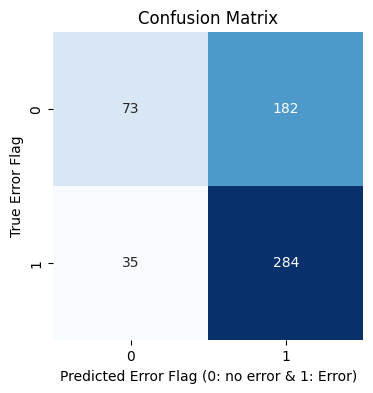

True Positives (TP): 284
False Positives (FP): 182
True Negatives (TN): 73
False Negatives (FN): 35
Precision: 0.61
Recall: 0.89
F1 Score: 0.72
Accuracy: 0.62


In [103]:
print_metrics('EA_shared_task_outputs/case1_26_03_2024/case_1_validMS_gpt_4_predictions_26_03_2024.csv','gpt_4_1106_preview_error_flag')

Shape of dataframe:(466, 8)
Shape of dataframe AFTER dropping NANs:(388, 8)
Shape of dataframe AFTER dropping NANs:(387, 9)
reevaluated_gpt_4_1106_preview_error_flag
0.0    244
1.0    143
Name: count, dtype: int64


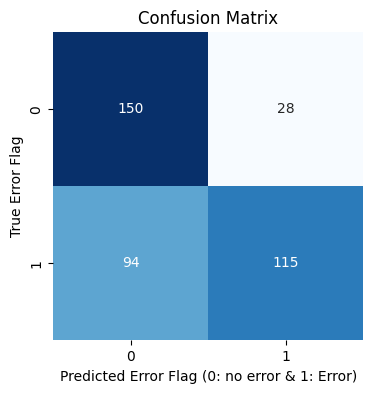

True Positives (TP): 115
False Positives (FP): 28
True Negatives (TN): 150
False Negatives (FN): 94
Precision: 0.80
Recall: 0.55
F1 Score: 0.65
Accuracy: 0.68


In [108]:
df_results = pd.read_csv('EA_shared_task_outputs/case1_26_03_2024/tempo.csv',index_col=0)

print(f"Shape of dataframe:{df_results.shape}",flush=True)
df_results = df_results.dropna(subset=['reevaluated_gpt_4_1106_preview_error_flag'])
print(f"Shape of dataframe AFTER dropping NANs:{df_results.shape}",flush=True)
df_results.reset_index(inplace=True)
def convert_value(value):
    if value in ['yes', 'Yes']:
        return 1
    elif value in ['No', 'no']:
        return 0
    else:
        return np.nan

df_results['reevaluated_gpt_4_1106_preview_error_flag'] = df_results['reevaluated_gpt_4_1106_preview_error_flag'].apply(convert_value)
df_results = df_results.dropna(subset=['reevaluated_gpt_4_1106_preview_error_flag'])
print(f"Shape of dataframe AFTER dropping NANs:{df_results.shape}",flush=True)
print(df_results['reevaluated_gpt_4_1106_preview_error_flag'].value_counts(dropna=False))
# df_results = df_results.iloc[:271]    
y_true = df_results['Error Flag']
y_pred = df_results['reevaluated_gpt_4_1106_preview_error_flag']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Error Flag (0: no error & 1: Error)')
plt.ylabel('True Error Flag')
plt.title('Confusion Matrix')
plt.show()
tn, fp, fn, tp = cm.ravel()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

In [104]:
## Read the pipeline1's output csv file
df = pd.read_csv('EA_shared_task_outputs/case1_26_03_2024/case_1_validMS_gpt_4_predictions_26_03_2024.csv',index_col=0)
df = df.dropna(subset=['gpt_4_1106_preview_error_flag'])
df['gpt_4_1106_preview_sentence_id'] = df['gpt_4_1106_preview_sentence_id'].astype(int)
df['gpt_4_1106_preview_error_flag'] = df['gpt_4_1106_preview_error_flag'].apply(convert_value)
print("ERROR FLAG: ",df['gpt_4_1106_preview_error_flag'].value_counts(dropna=False))
df.reset_index(inplace=True)
print("df.shape: ",df.shape)

## Extract only the positive predictions by gpt-4 api
df_0_preds = df[df['gpt_4_1106_preview_error_flag'] ==0]
df_0_preds.reset_index(inplace=True)
df_0_preds.shape

ERROR FLAG:  gpt_4_1106_preview_error_flag
1    466
0    108
Name: count, dtype: int64
df.shape:  (574, 13)


(108, 14)

In [105]:
df_0_preds.columns

Index(['index', 'Unnamed: 0', 'Text ID', 'Text', 'Sentences', 'Error Flag',
       'Error Sentence ID', 'Error Sentence', 'Corrected Sentence',
       'Corrected Text', 'gpt_4_1106_preview_error_flag',
       'gpt_4_1106_preview_sentence_id', 'gpt_4_1106_preview_Error_Sentence',
       'gpt_4_1106_preview_Corrected_Sentence'],
      dtype='object')

In [83]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
df = pd.read_csv('EA_shared_task_outputs/case2_prompt_with_RAG/case2_with_RAG_validMS_gpt_4_predictions_temp_27_03.csv',index_col=0)
df = df.iloc[:178]
df = df.dropna(subset=['gpt_4_1106_preview_error_flag'])
df = df.dropna(subset=['reevaluated_gpt_4_1106_preview_error_flag'])
df = df.dropna(subset=['Error Flag'])


df.reset_index(inplace=True)
print(df.shape)
def convert_value(value):
        if value in ['yes', 'Yes']:
            return 1
        elif value in ['No', 'no']:
            return 0
        else:
            return np.nan
    
df['reevaluated_gpt_4_1106_preview_error_flag'] = df['reevaluated_gpt_4_1106_preview_error_flag'].apply(convert_value)
df = df.dropna(subset=['gpt_4_1106_preview_error_flag', 'reevaluated_gpt_4_1106_preview_error_flag'])
print(df.shape)

def evaluate_metrics(y_true, y_pred, metric_names=["Accuracy", "Precision", "Recall", "F1", "ROC AUC"]):
    metrics = {}
    if "Accuracy" in metric_names:
        metrics["Accuracy"] = accuracy_score(y_true, y_pred)
    if "Precision" in metric_names:
        metrics["Precision"] = precision_score(y_true, y_pred)
    if "Recall" in metric_names:
        metrics["Recall"] = recall_score(y_true, y_pred)
    if "F1" in metric_names:
        metrics["F1"] = f1_score(y_true, y_pred)
    if "ROC AUC" in metric_names:
        if y_true.nunique() == 2 and y_pred.nunique() == 2:
            metrics["ROC AUC"] = roc_auc_score(y_true, y_pred)
        else:
            metrics["ROC AUC"] = "N/A (not binary)"
    return metrics

gold_standard = "Error Flag"
model_1_predictions = "gpt_4_1106_preview_error_flag"
model_2_predictions = "reevaluated_gpt_4_1106_preview_error_flag"

metrics_model_1 = evaluate_metrics(df[gold_standard], df[model_1_predictions])
metrics_model_2 = evaluate_metrics(df[gold_standard], df[model_2_predictions])

print("Evaluation Metrics for Model 1:")
for metric, value in metrics_model_1.items():
    if isinstance(value, str):
        print(f"{metric}: {value}")
    else:
        print(f"{metric}: {value:.4f}")

print("\nEvaluation Metrics for Model 2:")
for metric, value in metrics_model_2.items():
    if isinstance(value, str):
        print(f"{metric}: {value}")
    else:
        print(f"{metric}: {value:.4f}")


(178, 20)
(178, 20)
Evaluation Metrics for Model 1:
Accuracy: 0.6461
Precision: 0.6461
Recall: 1.0000
F1: 0.7850
ROC AUC: N/A (not binary)

Evaluation Metrics for Model 2:
Accuracy: 0.7247
Precision: 0.8173
Recall: 0.7391
F1: 0.7763
ROC AUC: 0.7188


# Understanding the input Training dataset

In [203]:
df_train_ms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          2189 non-null   int64 
 1   Text ID             2189 non-null   object
 2   Text                2189 non-null   object
 3   Sentences           2189 non-null   object
 4   Error Flag          2189 non-null   int64 
 5   Error Sentence ID   2189 non-null   int64 
 6   Error Sentence      1219 non-null   object
 7   Corrected Sentence  1219 non-null   object
 8   Corrected Text      1219 non-null   object
dtypes: int64(3), object(6)
memory usage: 154.0+ KB


In [181]:
df_train_ms['Error Flag'].value_counts(dropna=False)

Error Flag
1    1219
0     970
Name: count, dtype: int64

In [183]:
df_train_ms['Error Sentence'][:10]

0    After reviewing imaging, the causal pathogen was determined to be Haemophilus influenzae.
1                                                                                          NaN
2                                                 Suspected of infection with Giardia lamblia.
3                                                                                          NaN
4                                               Causal organism is Staphylococcus epidermidis.
5                                                                                          NaN
6                                                  Patient is diagnosed with an EBV infection.
7                                                                                          NaN
8                                   Bartonella henselae was determined as the causal organism.
9                                                        Culture confirms Nocardia asteroides.
Name: Error Sentence, dtype: object

In [ ]:
error_text = ' '.join(df_train_ms['Error Sentence'].dropna().str.lower())
corrected_text = ' '.join(df_train_ms['Corrected Sentence'].dropna().str.lower())

wordcloud_error = WordCloud(stopwords=STOPWORDS, background_color='white').generate(error_text)
wordcloud_corrected = WordCloud(stopwords=STOPWORDS, background_color='white').generate(corrected_text)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_error, interpolation='bilinear')
plt.title('Error Sentences')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_corrected, interpolation='bilinear')
plt.title('Corrected Sentences')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
df_train_ms['Text'].apply(len).plot(kind='hist', bins=20, alpha=0.7)
plt.title('Frequency of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# CASE 1: 7 examples given in Prompt with every feature 
## (Text, Sentences, Error flag, Error sentence id, error sentence, corrected sentence)

In [ ]:
# CASE When "or text span" is removed and "gpt-4-turbo-preview" is used
df_val_ms = pd.read_csv('MEDIQA-CORR-2024-MS-ValidationSet-1-Full.csv')
df_val_ms['gpt_4_1106_preview_error_flag'] = 0
df_val_ms['gpt_4_1106_preview_sentence_id'] = 0
df_val_ms['gpt_4_1106_preview_Error_Sentence'] = ''
df_val_ms['gpt_4_1106_preview_Corrected_Sentence'] = ''

max_retries = 3
default_wait_time = 6  # Default wait time in seconds

# for i in range(len(df_val_ms)):
for i, row in df_val_ms.iterrows():
    print("#######################################################################")
    time.sleep(30)
    if i % 5 == 0:
        # print("Waiting for 10 seconds...",flush=True)
        time.sleep(10)
        
    retry_count = 0
    while retry_count < max_retries:
        try:
            print(f"Currently accessing df_val_ms id:{i}", flush=True)
            text = row['Text']
            clinical_sentences = row['Sentences']
            # print("Data read!!")
            message_text = [{"role":"system","content":
                  f"""You are an AI trained in medical knowledge. Below are examples of clinical texts (delimited by triple quotes) and clinical texts divided into sentences (delimited by triple quotes) followed by an analysis of whether there is a diagnostic error and, if so, the sentence ID and the text span containing the error. The examples also show the corrected sentence that should have been the correct diagnosis.
                  Example 1:
                  Clinical Text: ```A 17-year-old boy comes to the physician because of body aches and sore throat for 1 week. He has no history of serious illness and takes no medications. He lives with his parents; they recently adopted a cat from an animal shelter. He is sexually active with one female partner, and they use condoms consistently. His temperature is 38.7 C (101.7 F), pulse is 99/min, and blood pressure is 110/72 mm Hg. Examination shows bilateral posterior cervical lymphadenopathy. The pharynx is red and swollen. Laboratory studies show:
                  Hemoglobin 15 g/dL
                  Leukocyte count 11,500/mm3
                  Segmented neutrophils 48%
                  Band forms 2%
                  Basophils 0.5%
                  Eosinophils 1%
                  Lymphocytes 45%
                  Monocytes 3.5%
                  When the patient's serum is added to a sample of horse erythrocytes, the cells aggregate together. The causal pathogen is cytomegalovirus.```
                  Clinical Text Sentences: ```0 A 17-year-old boy comes to the physician because of body aches and sore throat for 1 week.
                  1 He has no history of serious illness and takes no medications.
                  2 He lives with his parents; they recently adopted a cat from an animal shelter.
                  3 He is sexually active with one female partner, and they use condoms consistently.
                  4 His temperature is 38.7 C (101.7 F), pulse is 99/min, and
                  5 blood pressure is 110/72 mm
                  6 Hg.
                  7 Examination shows bilateral posterior cervical lymphadenopathy.
                  8 The pharynx is red and swollen.
                  9 Laboratory studies show:
                  10 Hemoglobin 15
                  11 g/dL
                  12 Leukocyte count 11,500/mm3 Segmented neutrophils 48%
                  13 Band forms 2%
                  14 Basophils 0.5%
                  15 Eosinophils 1%
                  16 Lymphocytes 45%
                  17 Monocytes 3.5%
                  18 When the patient's serum is added to a sample of horse erythrocytes, the cells aggregate together.
                  19 The causal pathogen is cytomegalovirus.```
                  Error: yes
                  Error Sentence ID: 19
                  Error Sentence Span: The causal pathogen is cytomegalovirus.
                  Corrected Sentence: The causal pathogen is Epstein-Barr virus.
                
                  Example 2:
                  Clinical Text: ```A previously healthy 18-year-old woman comes to the emergency department because of diarrhea and abdominal cramps since the previous evening. She has had around 3Ã¢â‚¬â€œ4 episodes of watery stools. She feels nauseous and has vomited twice. She recollects eating out 2 days ago. She has been on a vegan diet for 6 months. She takes no medications and has not traveled anywhere recently. Her temperature is 36.8 (98.2 F), pulse is 73/min, and blood pressure is 110/70 mm Hg. Examination shows dry mucous membranes. Abdominal examination is unremarkable. Norovirus was determined to be the casual organism.```
                  Clinical Text Sentences: ```0 A previously healthy 18-year-old woman comes to the emergency department because of diarrhea and abdominal cramps since the previous evening.
                  1 She has had around 3Ã¢â‚¬â€œ4 episodes of watery stools.
                  2 She feels nauseous and has vomited twice.
                  3 She recollects eating out 2 days ago.
                  4 She has been on a vegan diet for 6 months.
                  5 She takes no medications and has not traveled anywhere recently.
                  6 Her temperature is 36.8 (98.2 F), pulse is 73/min, and
                  7 blood pressure is 110/70 mm
                  8 Hg.
                  9 Examination shows dry mucous membranes.
                  10 Abdominal examination is unremarkable.
                  11 Norovirus was determined to be the casual organism.```
                  Error: No
                  Error Sentence ID: -1
                  Error Sentence Span: -1
                  Corrected Sentence: -1
                
                  Example 3:
                  Clinical Text: ```A 5-year-old boy is brought to the emergency department by his grandmother because of difficulty breathing. Over the past two hours, the grandmother has noticed his voice getting progressively hoarser and occasionally muffled, with persistent drooling. He has not had a cough. The child recently immigrated from Africa, and the grandmother is unsure if his immunizations are up-to-date. He appears uncomfortable and is sitting up and leaning forward with his chin hyperextended. His temperature is 39.5 C (103.1 F), pulse is 110/min, and blood pressure is 90/70 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 95%. Pulmonary examination shows inspiratory stridor and scattered rhonchi throughout both lung fields, along with poor air movement. Pharyngoscopy is ordered. ```
                  Clinical Text Sentences: ```0 A 5-year-old boy is brought to the emergency department by his grandmother because of difficulty breathing.
                  1 Over the past two hours, the grandmother has noticed his voice getting progressively hoarser and occasionally muffled, with persistent drooling.
                  2 He has not had a cough.
                  3 The child recently immigrated from Africa, and the grandmother is unsure if his immunizations are up-to-date.
                  4 He appears uncomfortable and is sitting up and leaning forward with his chin hyperextended.
                  5 His temperature is 39.5 C (103.1 F), pulse is 110/min, and blood pressure is 90/70 mm
                  6 Hg.
                  7 Pulse oximetry on room air shows an oxygen saturation of 95%.
                  8 Pulmonary examination shows inspiratory stridor and scattered rhonchi throughout both lung fields, along with poor air movement.
                  9 Pharyngoscopy is ordered.```
                  Error: yes
                  Error Sentence ID: 9
                  Error Sentence Span: Pharyngoscopy is ordered.
                  Corrected Sentence: Nasotracheal intubation is performed.
                
                  Example 4:
                  Clinical Text:```A 28-year-old man is brought to the emergency department after being struck by a car an hour ago as he was crossing the street. He did not lose consciousness. He is complaining of pain in his right arm, forehead, and pelvis. He also has the urge to urinate, but has been unable to do so since the accident. He takes no medications. His temperature is 37.1 C (98.9 F), pulse is 72/min, respirations are 18/min, and blood pressure is 118/82 mm Hg. There are abrasions over his scalp and face and a 1x3 cm area of ecchymosis above his right eye. Abdominal examination shows suprapubic tenderness. There is a scant amount of blood at the urethral meatus. There is no cervical spinal tenderness. Musculoskeletal examination shows tenderness and ecchymosis over his right distal forearm. An x-ray of the pelvis shows a fracture of the pelvic ramus. Retrograde urethrogram was then performed. A CT scan of the head and neck show no abnormalities.```
                  Clinical Text Sentences: ```0 A 28-year-old man is brought to the emergency department after being struck by a car an hour ago as he was crossing the street.
                  1 He did not lose consciousness.
                  2 He is complaining of pain in his right arm, forehead, and pelvis.
                  3 He also has the urge to urinate, but has been unable to do so since the accident.
                  4 He takes no medications.
                  5 His temperature is 37.1 C (98.9 F), pulse is 72/min, respirations are 18/min, and
                  6 blood pressure is 118/82 mm
                  7 Hg.
                  8 There are abrasions over his scalp and face and a 1x3 cm area of ecchymosis above his right eye.
                  9 Abdominal examination shows suprapubic tenderness.
                  10 There is a scant amount of blood at the urethral meatus.
                  11 There is no cervical spinal tenderness.
                  12 Musculoskeletal examination shows tenderness and ecchymosis over his right distal forearm.
                  13 An x-ray of the pelvis shows a fracture of the pelvic ramus.
                  14 Retrograde urethrogram was then performed.
                  15 A CT scan of the head and neck show no abnormalities.```
                  Error: No
                  Error Sentence ID: -1
                  Error Sentence Span: -1
                  Corrected Sentence: -1
                
                  Example 5:
                  Clinical Text: ```A 28-year-old man is brought to the emergency department after being struck by a car an hour ago as he was crossing the street. He did not lose consciousness. He is complaining of pain in his right arm, forehead, and pelvis. He also has the urge to urinate, but has been unable to do so since the accident. He takes no medications. His temperature is 37.1 C (98.9 F), pulse is 72/min, respirations are 18/min, and blood pressure is 118/82 mm Hg. There are abrasions over his scalp and face and a 1x3 cm area of ecchymosis above his right eye. Abdominal examination shows suprapubic tenderness. There is a scant amount of blood at the urethral meatus. There is no cervical spinal tenderness. Musculoskeletal examination shows tenderness and ecchymosis over his right distal forearm. An x-ray of the pelvis shows a fracture of the pelvic ramus. A CT scan of the head and neck show no abnormalities. IV pyelogram was then performed.```
                  Clinical Text Sentences: ```0 A 28-year-old man is brought to the emergency department after being struck by a car an hour ago as he was crossing the street.
                  1 He did not lose consciousness.
                  2 He is complaining of pain in his right arm, forehead, and pelvis.
                  3 He also has the urge to urinate, but has been unable to do so since the accident.
                  4 He takes no medications.
                  5 His temperature is 37.1 C (98.9 F), pulse is 72/min, respirations are 18/min, and
                  6 blood pressure is 118/82 mm
                  7 Hg.
                  8 There are abrasions over his scalp and face and a 1x3 cm area of ecchymosis above his right eye.
                  9 Abdominal examination shows suprapubic tenderness.
                  10 There is a scant amount of blood at the urethral meatus.
                  11 There is no cervical spinal tenderness.
                  12 Musculoskeletal examination shows tenderness and ecchymosis over his right distal forearm.
                  13 An x-ray of the pelvis shows a fracture of the pelvic ramus.
                  14 A CT scan of the head and neck show no abnormalities.
                  15 IV pyelogram was then performed.```
                  Error: yes
                  Error Sentence ID: 15
                  Error Sentence Span: IV pyelogram was then performed.
                  Corrected Sentence: Retrograde urethrogram was then performed.
                
                  Example 6:
                  Clinical Text: ```A previously healthy 25-year-old man comes to the physician because of a 4-day history of fever, joint and body pain, diffuse headache, and pain behind the eyes. This morning he noticed that his gums bled when he brushed his teeth. He returned from a backpacking trip to the Philippines 4 days ago. His temperature is 39.4 C (103.0 F). Physical examination shows a diffuse maculopapular rash. His leukocyte count is 3,200/mm3 and platelet count is 89,000/mm3. Further evaluation shows increased serum levels of a flavivirus. The patient is infected by the chikungunya virus.```
                  Clinical Text Sentences: ```0 A previously healthy 25-year-old man comes to the physician because of a 4-day history of fever, joint and body pain, diffuse headache, and pain behind the eyes.
                  1 This morning he noticed that his gums bled when he brushed his teeth.
                  2 He returned from a backpacking trip to the Philippines 4 days ago.
                  3 His temperature is 39.4 C (103.0 F).
                  4 Physical examination shows a diffuse maculopapular rash.
                  5 His leukocyte count is
                  6 3,200/mm3 and platelet count is 89,000/mm3.
                  7 Further evaluation shows increased serum levels of a flavivirus.
                  8 The patient is infected by the chikungunya virus.```
                  Error: yes
                  Error Sentence ID: 8
                  Error Sentence Span: The patient is infected by the chikungunya virus.
                  Corrected Sentence: The patient is infected by the Dengue virus.
                
                  Example 7:
                  Clinical Text: ```A previously healthy 25-year-old man comes to the physician with suspected Dengue viral infection because of a 4-day history of fever, joint and body pain, diffuse headache, and pain behind the eyes. This morning he noticed that his gums bled when he brushed his teeth. He returned from a backpacking trip to the Philippines 4 days ago. His temperature is 39.4 C (103.0 F). Physical examination shows a diffuse maculopapular rash. His leukocyte count is 3,200/mm3 and platelet count is 89,000/mm3. Further evaluation shows increased serum levels of a flavivirus.```
                  Clinical Text Sentences: ```0 A previously healthy 25-year-old man comes to the physician with suspected Dengue viral infection because of a 4-day history of fever, joint and body pain, diffuse headache, and pain behind the eyes.
                  1 This morning he noticed that his gums bled when he brushed his teeth.
                  2 He returned from a backpacking trip to the Philippines 4 days ago.
                  3 His temperature is 39.4 C (103.0 F).
                  4 Physical examination shows a diffuse maculopapular rash.
                  5 His leukocyte count is
                  6 3,200/mm3 and platelet count is 89,000/mm3.
                  7 Further evaluation shows increased serum levels of a flavivirus.```
                  Error: No
                  Error Sentence ID: -1
                  Error Sentence Span: -1
                  Corrected Sentence: -1
                
                  Now, given a new clinical text delimited by triple quotes, carefully evaluate and analyse the clinical information presented such as symptoms, clinical examination findings, patient history and other details. Determine if there is a diagnostic error or not based on this information. If an error is present, identify the specific sentence ID (and the sentence with that ID) that contains this error and also correct this erroneous sentence based on the rest of clinical text. Use your knowledge and the context provided to make your assessment.

                  Clinical Text: ```{text}```
                  Clinical Text Sentences: ```{clinical_sentences}```
                
                  Provide the answers in JSON Format with the following keys:
                  Error, Error Sentence ID, Error Sentence, Corrected Sentence
                  """
                  }]

            completion = openai.ChatCompletion.create(engine=<engine name>,messages = message_text,
                          temperature=0, max_tokens=800,
                          top_p=0.95, frequency_penalty=0,
                          presence_penalty=0, stop=None)
            
            message_content = completion["choices"][0]["message"]["content"].strip('```json\n').strip('\n```')
            message_content_json = json.loads(message_content)
            # print(message_content_json)
            df_val_ms.at[i, 'gpt_4_1106_preview_error_flag'] = message_content_json['Error']
            df_val_ms.at[i, 'gpt_4_1106_preview_sentence_id'] = message_content_json['Error Sentence ID']
            df_val_ms.at[i, 'gpt_4_1106_preview_Error_Sentence'] = message_content_json['Error Sentence']
            df_val_ms.at[i, 'gpt_4_1106_preview_Corrected_Sentence'] = message_content_json['Corrected Sentence']
            df_val_ms.to_csv('case_1_validMS_gpt_4_predictions_temp_file.csv',index=False)
            break

        except openai.error.APIConnectionError as e:
            print(f"Timeout error encountered at index {i}, attempt {retry_count + 1}: {e}", flush=True)
            retry_count += 1
            time.sleep(default_wait_time)  # Wait before retrying

        except openai.error.InvalidRequestError as e:
            print(f"InvalidRequestError at index {i}: {e}", flush=True)
            break

        except openai.error.RateLimitError as e:
            match = re.search(r"Please retry after (\d+) seconds", str(e))
            if match:
                wait_time = int(match.group(1)) + 1  # Add a 1-second buffer
            else:
                wait_time = default_wait_time
            print(f"RateLimitError at index {i}. Retrying after {wait_time} seconds.", flush=True)
            time.sleep(wait_time)
            retry_count += 1

        except openai.error.OpenAIError as e:
            print(f"Unexpected OpenAIError encountered at index {i}: {e}", flush=True)
            break 

        except Exception as e:
            print(f"Unexpected error encountered at index {i}: {e}", flush=True)
            break

df_val_ms.to_csv('case_1_validMS_gpt_4_predictions_26_03_2024.csv',index=False)
print("Final csv saved!!",flush=True)

#######################################################################
Currently accessing df_val_ms id:0


/tmp/ipykernel_3357267/21538612.py:195: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'yes' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_val_ms.at[i, 'gpt_4_1106_preview_error_flag'] = message_content_json['Error']


#######################################################################
Currently accessing df_val_ms id:1
#######################################################################
Currently accessing df_val_ms id:2
#######################################################################
Currently accessing df_val_ms id:3
#######################################################################
Currently accessing df_val_ms id:4
#######################################################################
Currently accessing df_val_ms id:5
#######################################################################
Currently accessing df_val_ms id:6
#######################################################################
Currently accessing df_val_ms id:7
#######################################################################
Currently accessing df_val_ms id:8
#######################################################################
Currently accessing df_val_ms id:9
#####################################

/tmp/ipykernel_3357267/21538612.py:196: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_val_ms.at[i, 'gpt_4_1106_preview_sentence_id'] = message_content_json['Error Sentence ID']


#######################################################################
Currently accessing df_val_ms id:14
#######################################################################
Currently accessing df_val_ms id:15
#######################################################################
Currently accessing df_val_ms id:16
#######################################################################
Currently accessing df_val_ms id:17
#######################################################################
Currently accessing df_val_ms id:18
#######################################################################
Currently accessing df_val_ms id:19
#######################################################################
Currently accessing df_val_ms id:20
#######################################################################
Currently accessing df_val_ms id:21
#######################################################################
Currently accessing df_val_ms id:22
############################

# Types of error i saw:

1. Timeout: Request timed out: HTTPSConnectionPool(host='sweden-api.openai.azure.com', port=443): Read timed out. (read timeout=600)

2. InvalidRequestError: The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766

3. Request timed out: HTTPSConnectionPool(host='sweden-api.openai.azure.com', port=443): Read timed out. (read timeout=600)


# Evaluation Scripts

In [274]:
'''
The submission format should follow the data format and consists of:

[Text ID] [Error Flag] [Error sentence ID or -1 for texts without errors] [Corrected sentence or NA for texts without errors]
'''
import csv

def csv_to_txt(input_csv, output_txt):
    with open(input_csv, mode='r', encoding='utf-8') as infile, open(output_txt, mode='w', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        for row in reader:
            text_id = row['Text ID']
            error_flag = '1' if row['GPT_4_error_flag'].strip().lower() == 'yes' else '0'
            sentence_id = row['GPT_4_sentence_id']
            corrected_sentence = row['GPT_4_Corrected_Sentence']
            if corrected_sentence == "-1":
                corrected_sentence = "NA"
            else:
                corrected_sentence = f"\"{corrected_sentence}\""
            
            line = f"{text_id} {error_flag} {sentence_id} {corrected_sentence}\n"
            outfile.write(line)

# Usage
csv_file = 'case_1.csv'  # Replace with your CSV file path
txt_file = 'case_1.txt'  # The output TXT file path
csv_to_txt(csv_file, txt_file)

In [278]:
import csv

def csv_to_txt(input_csv, output_txt):
    with open(input_csv, mode='r', encoding='utf-8') as infile, open(output_txt, mode='w', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        for row in reader:
            text_id = row['Text ID']
            # Convert the flags to a uniform format (numerical) for comparison
            original_error_flag = row['Error Flag'].strip()
            gpt_error_flag = '1' if row['GPT_4_error_flag'].strip().lower() == 'yes' else '0'

            # Proceed only if the error flags match
            if original_error_flag == gpt_error_flag:
                sentence_id = row['GPT_4_sentence_id']
                corrected_sentence = row['GPT_4_Corrected_Sentence']
                if corrected_sentence == "-1":
                    corrected_sentence = "NA"
                else:
                    corrected_sentence = f"\"{corrected_sentence}\""

                # Formatting the line to be written in the text file
                line = f"{text_id} {gpt_error_flag} {sentence_id} {corrected_sentence}\n"
                outfile.write(line)

# Usage
csv_file = 'case_1.csv'  # Replace with your CSV file path
txt_file = 'case_1_GPT_accurate_cases.txt'  # The output TXT file path
csv_to_txt(csv_file, txt_file)


In [266]:
pip install rouge

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [268]:
import re
import pandas as pd
from rouge import Rouge
import scipy.stats as stats
import numpy as np
import math
import string

In [269]:
#################
# Parsing Funcs #
#################


def parse_reference_file(filepath):
    """Parsing reference file path.

    Returns:
        reference_corrections (dict) {text_id: "reference correction"}
        reference_flags (dict) {text_id: "1 or 0 error flag"}
        reference_sent_id (dict) {text_id: "error sentence id or -1"}
    
    """

    reference_corrections = {}
    reference_flags = {}
    reference_sent_id = {}

    df = pd.read_csv(filepath)
    
    for index, row in df.iterrows():
        text_id = row['Text ID']
        corrected_sentence = row['Corrected Sentence']
        
        if not isinstance(corrected_sentence, str):
            if math.isnan(corrected_sentence):
                corrected_sentence = "NA"
            else:
                corrected_sentence = str(corrected_sentence)
                corrected_sentence = corrected_sentence.replace("\n", " ") \
                  .replace("\r", " ").strip()
                  
        reference_corrections[text_id] = corrected_sentence
        reference_flags[text_id] = str(row['Error Flag'])
        reference_sent_id[text_id] = str(row['Error Sentence ID'])

    return reference_corrections, reference_flags, reference_sent_id


def parse_run_submission_file(filepath):
    
    file = open(filepath, 'r')

    candidate_corrections = {}
    predicted_flags = {}
    candidate_sent_id = {}
    
    lines = file.readlines()
    
    for line in lines:
        line = line.strip()
        
        if len(line) == 0:
            continue
            
        if not re.fullmatch('[a-z0-9\-]+\s[0-9]+\s\-?[0-9]+\s.+', line):
            print("Invalid line: ", line)
            continue
            
        # replacing consecutive spaces
        line = re.sub('\s+', line, ' ')
        
        # parsing
        items = line.split()
        text_id = items[0]
        error_flag = items[1]
        sentence_id = items[2]
        corrected_sentence = ' '.join(items[3:]).strip()
        
        # debug - parsing check
        # print("{} -- {} -- {} -- {}".format(text_id, error_flag, sentence_id, corrected_sentence))

        predicted_flags[text_id] = error_flag
        candidate_sent_id[text_id] = sentence_id

        # processing candidate corrections
        # removing quotes

        while corrected_sentence.startswith('"') and len(corrected_sentence) > 1:
            corrected_sentence = corrected_sentence[1:]
            
        while corrected_sentence.endswith('"') and len(corrected_sentence) > 1:
            corrected_sentence = corrected_sentence[:-1]
                   
        if error_flag == '0':
            # enforcing "NA" in predicted non-errors (used for consistent/reliable eval)
            candidate_corrections[text_id] = "NA"
        else:
            candidate_corrections[text_id] = corrected_sentence

    return candidate_corrections, predicted_flags, candidate_sent_id


##############
# Eval Funcs #
##############

def compute_accuracy(reference_flags, reference_sent_id, predicted_flags, candidate_sent_id):
    # Error Flags Accuracy (missing predictions are counted as false)
    matching_flags_nb = 0
    
    for text_id in reference_flags:
        if text_id in predicted_flags and reference_flags[text_id] == predicted_flags[text_id]:
            matching_flags_nb += 1
            
    flags_accuracy = matching_flags_nb / len(reference_flags)
    
    # Error Sentence Detection Accuracy (missing predictions are counted as false)
    matching_sentence_nb = 0
    
    for text_id in reference_sent_id:
        if text_id in candidate_sent_id and candidate_sent_id[text_id] == reference_sent_id[text_id]:
            matching_sentence_nb += 1
            
    sent_accuracy = matching_sentence_nb / len(reference_sent_id)

    return {
        "Error Flags Accuracy": flags_accuracy,
        "Error Sentence Detection Accuracy": sent_accuracy
    }

def increment_counter(counters, counter_name):
    counters[counter_name] = counters[counter_name] + 1

class NLGMetrics(object):

    def __init__(self, metrics = ['ROUGE']):
        self.metrics = metrics
    
    def compute(self, references, predictions, counters):
        results = {}
        
        if 'ROUGE' in self.metrics:
            rouge = Rouge() 
            rouge_scores = rouge.get_scores(predictions, references)
                            
            rouge1f_scores = []
            rouge2f_scores = []
            rougeLf_scores = []
            
            for i in range(len(references)):
                r1f = rouge_scores[i]["rouge-1"]["f"]
                r2f = rouge_scores[i]["rouge-2"]["f"]
                rlf = rouge_scores[i]["rouge-l"]["f"]
                
                rouge1f_scores.append(r1f)	
                rouge2f_scores.append(r2f)
                rougeLf_scores.append(rlf)
                
            # for checking comparison with composite
            rouge1check = np.array(rouge1f_scores).mean()
            rouge2check = np.array(rouge2f_scores).mean()
            rougeLcheck = np.array(rougeLf_scores).mean()

            results['R1F_subset_check'] = rouge1check
            results['R2F_subset_check'] = rouge2check
            results['RLF_subset_check'] = rougeLcheck
            
            ###############################
            # Composite score computation #
            ###############################
            
            """
            NLG METRIC on sentence vs. sentence cases + ones or zeros 
            when either the reference or the candidate correction is NA
            """
            
            rouge1score = np.array(rouge1f_scores).sum()
            rouge2score = np.array(rouge2f_scores).sum()
            rougeLscore = np.array(rougeLf_scores).sum()
            
            composite_score_rouge1 = (rouge1score + counters["system_provided_correct_na"]) / counters["total_texts"]
            composite_score_rouge2 = (rouge2score + counters["system_provided_correct_na"]) / counters["total_texts"]
            composite_score_rougeL = (rougeLscore + counters["system_provided_correct_na"]) / counters["total_texts"]

            results['R1FC'] = composite_score_rouge1
            results['R2FC'] = composite_score_rouge2
            results['RLFC'] = composite_score_rougeL

        
        return results


def get_nlg_eval_data(reference_corrections, candidate_corrections, remove_nonprint = False):
    references = []
    predictions = []
    
    counters = {
        "total_texts": 0,
        "reference_na": 0,
        "total_system_texts": 0,
        "system_provided_na": 0,
        "system_provided_correct_na": 0,
    }
    
    for text_id in reference_corrections:
        increment_counter(counters, "total_texts")
        
        # removing non ascii chars
        reference_correction = reference_corrections[text_id]
        
        if remove_nonprint:
            reference_correction = ''.join(filter(lambda x: x in string.printable, str(reference_correction)))
            
        if reference_correction == "NA":
            increment_counter(counters, "reference_na")
            
        if text_id in candidate_corrections:
            increment_counter(counters, "total_system_texts")
            candidate = candidate_corrections[text_id]
            
            if remove_nonprint:
                candidate = ''.join(filter(lambda x: x in string.printable, candidate))
                
            if candidate == "NA":
                increment_counter(counters, "system_provided_na")
                
            # matching NA counts as 1
            if reference_correction == "NA" and candidate == "NA":
                increment_counter(counters, "system_provided_correct_na")
                continue
                
            # Run provided "NA" when a correction was required (=> 0)
            # or Run provided a correction when "NA" was required (=> 0)
            if candidate == "NA" or reference_correction == "NA":
                continue
                
            # remaining case is both reference and candidate are not "NA"
            # both are inserted/added for ROUGE/BLEURT/etc. computation
            references.append(reference_correction)
            predictions.append(candidate)
    

    
    return references, predictions, counters

In [275]:
submission_file = "case_1.txt"
reference_csv_file = "MEDIQA-CORR-2024-MS-TrainingData.csv"

reference_corrections, reference_flags, reference_sent_id = parse_reference_file(reference_csv_file)
candidate_corrections, candidate_flags, candidate_sent_id = parse_run_submission_file(submission_file)

# Accuracy
accuracy_results = compute_accuracy(reference_flags, reference_sent_id, candidate_flags, candidate_sent_id)
print("Accuracy Results:\n", accuracy_results)
print()

# NLG Eval for corrections
references, predictions, counters = get_nlg_eval_data(reference_corrections, candidate_corrections)
metrics = NLGMetrics()
nlg_eval_results = metrics.compute(references, predictions, counters) 

print("NLG Eval Results:\n", nlg_eval_results) 
print()

# debug check
print(counters)
print()

Invalid line:  ms-train-426 0  "nan"
Invalid line:  ms-train-637 0  "nan"
Invalid line:  ms-train-750 0  "nan"
Invalid line:  ms-train-937 0  "nan"
Invalid line:  ms-train-938 0  "nan"
Invalid line:  ms-train-968 0  "nan"
Invalid line:  ms-train-969 0  "nan"
Invalid line:  ms-train-1003 0  "nan"
Invalid line:  ms-train-1108 0  "nan"
Invalid line:  ms-train-1276 0  "nan"
Accuracy Results:
 {'Error Flags Accuracy': 0.6359068067610781, 'Error Sentence Detection Accuracy': 0.6222019186843307}

NLG Eval Results:
 {'R1F_subset_check': 0.5894396772329137, 'R2F_subset_check': 0.4736292629615664, 'RLF_subset_check': 0.5842031368423116, 'R1FC': 0.433533765068211, 'R2FC': 0.37644859512815443, 'RLFC': 0.430952574076224}

{'total_texts': 2189, 'reference_na': 970, 'total_system_texts': 2179, 'system_provided_na': 447, 'system_provided_correct_na': 313}

